# Import Libraries

In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.naive_bayes import CategoricalNB,MultinomialNB

In [90]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Prepration

In [91]:
train_df = pd.read_csv('train_data.csv')[['New_Sentence', 'Type']]
test_df = pd.read_csv('test_data.csv')

<AxesSubplot: >

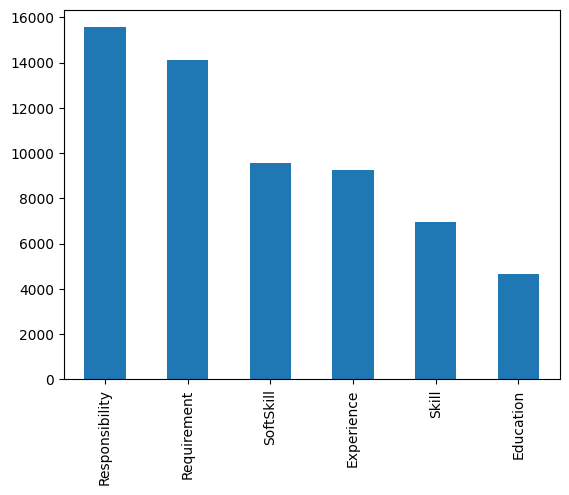

In [92]:
train_df.Type.value_counts().plot(kind='bar')

## Data Preprocessing

## Remove invalid(Na) sentences

In [93]:
train_df.isna().sum()

New_Sentence    1113
Type               0
dtype: int64

In [94]:
train_df = train_df.dropna()

## Data split

In [95]:
raw_train_x,raw_dev_x,train_y,dev_y = train_test_split( train_df.New_Sentence, train_df.Type, test_size=0.2,stratify=train_df.Type, random_state=2)

## Data Processing

### Data Cleaning

In [96]:
# lower case 
train_x = raw_train_x.apply(lambda x:x.lower())
# remove puctutation
train_x = train_x.apply(lambda x:re.sub(r'[^\w\s]','',x))
# split words
train_x = train_x.apply(lambda x:x.split())

In [97]:
vocab = Counter()
for words in train_x.tolist():
    vocab.update(words)

### Vocab Buliding

In [98]:
## remove rare words
min_theshold = 5
vocab = {word: count for word,count in vocab.items() if count>=min_theshold}

## remove stop words
vocab = {word: count for word,count in vocab.items() if word not in stopwords.words('english')}
vocab = vocab.keys()

### Create Features from our sentence

In [99]:
def feature(x):
    cntr = Counter(x)
    return [1 if word in cntr else 0 for word in vocab]

In [100]:
tf_train_x = train_x.apply(lambda x :feature(x))
train_df = pd.DataFrame(np.array(tf_train_x.tolist()),columns=list(vocab))


In [101]:
train_df['Type']= train_y.values

In [70]:
class_prob = train_df['Type'].value_counts()/len(train_df)

In [87]:
feature_prob = {}

In [84]:
temp_df = train_df[train_df['Type']=='SoftSkill'][vocab]
(temp_df.sum()+1)/(temp_df.sum().sum()+len(vocab))

experience     0.008905
10             0.000057
12             0.000019
years          0.000151
efficient      0.000283
                 ...   
productos      0.000019
specs          0.000038
300            0.000038
shareholder    0.000019
cpu            0.000019
Length: 5682, dtype: float64

In [88]:
for class_name in class_prob.index:
    temp_df = train_df[train_df['Type']==class_name][vocab]
    feature_prob[class_name] = ((temp_df.sum()+1)/(temp_df.sum().sum()+len(vocab))).to_dict()

In [23]:
train_df['Type'] = train_y.values

## Naive bayes

In [103]:
class Naive_bayes:
    def __init__(self,smoothing =0):
        self.feature_prob = {}
        self.class_prob = {}
        self.smoothing = smoothing
    def train(self,train_data,vocab,target="Type"):
        ## Calculate the Class Proabbility P(c) = Number of examples with class C / total number of examples in dataset
        print(self.smoothing)
        if self.smoothing is None:
            self.class_prob = train_data[target].value_counts()/len(train_data)
        elif self.smoothing == "laplace":
            self.class_prob = train_data[target].value_counts()+1/(len(train_data)+train_data[target].nunique())


        ## Calculate the conditional feature probablility P(f | C) = Number of exmaples for class C with feature f / total number of examples of class C in dataset

        ## Here we also used Laplace smoothing 
        for class_name in self.class_prob.index:
            if self.smoothing is None:
                feature_prob_curr = train_data[train_data[target]==class_name][list(vocab)].sum()/(train_data[train_data[target]==class_name][list(vocab)].sum().sum())
            elif self.smoothing == "laplace":
                feature_prob_curr= (train_data[train_data[target]==class_name][list(vocab)].sum()+1)/(train_data[train_data[target]==class_name][list(vocab)].sum().sum()+len(vocab))
            self.feature_prob[class_name] = dict(feature_prob_curr)

    def predict(self,test_df):
        return test_df.apply(self.predict_helper)

    def predict_helper(self,x):
        log_prob = defaultdict(int)
        cntr = Counter(x)
        for class_name in self.class_prob.index:
            for word in cntr.keys():
                if  self.feature_prob[class_name].get(word,0) != 0 : 
                    log_prob[class_name]  += np.log(self.feature_prob[class_name][word])
            log_prob[class_name] += np.log(self.class_prob[class_name])
        return max(log_prob,key=log_prob.get)

In [116]:
nb_classifier = Naive_bayes("laplace")
nb_classifier.train(train_df,vocab)

laplace


In [105]:
dev_x = raw_dev_x.apply(lambda x:x.lower())
dev_x = dev_x.apply(lambda x:re.sub(r'[^\w\s]','',x))
dev_x = dev_x.apply(lambda x:x.split())

In [30]:
tf_dev_x = dev_x.apply(lambda x :feature(x))
dev_df = pd.DataFrame(np.array(tf_dev_x.tolist()),columns=list(vocab))
dev_df['Type'] = dev_y.values

In [46]:
model = MultinomialNB()
model.fit(train_df.drop(['Type'],axis=1),train_df['Type'])

MultinomialNB()

In [117]:
preds = nb_classifier.predict(dev_x)

In [118]:
(preds == dev_y).sum()/len(preds)

0.6912126091009236

In [52]:
def predict(x):
    log_prob = defaultdict(int)
    for class_name in class_prob.index:
        for word in x:
            if  word in feature_prob[class_name]: log_prob[class_name]  += np.log(feature_prob[class_name][word])
        log_prob[class_name] += np.log(class_prob[class_name])
    return max(log_prob,key=log_prob.get)

In [53]:
dev_x[:4].

/var/folders/pv/kkt12mzd5ddd8dpp0m9z4tbh0000gn/T/ipykernel_39374/3554358002.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dev_x[:4].apply(lambda x: predict(x))


7128     Responsibility
5890        Requirement
32641       Requirement
28434         SoftSkill
Name: New_Sentence, dtype: object